### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [3]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
import time
# %%time


In [4]:
dataset = pd.read_csv('Data/cleaned_data.csv')
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [6]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebook/' location
import sqlite3
from sqlite3 import Error

def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    create_connection("lead_scoring_model_experimentation.db")

2.6.0


In [7]:
# create a mlflow tracking uri at "http://0.0.0.0:6007"
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# mlflow.set_tracking_uri("file:///mnt/f/github/mlruns-tracking")


In [9]:
# from pycaret.classification import setup

exp_lead_scoring = setup(
    data=dataset,
    target='app_complete_flag',
    fold_shuffle=True,
    session_id=42,
    normalize=True,
    transformation=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    n_jobs=-1,
    use_gpu=False,
    log_experiment=False,
    experiment_name='Lead_scoring_model_experimentation',
    log_plots=False,
    log_data=False,
    verbose=True,
    log_profile=False
)


,Description,Value
0,Session id,42
1,Target,app_complete_flag
2,Target type,Binary
3,Original data shape,"(238964, 12)"
4,Transformed data shape,"(238964, 44)"
5,Transformed train set shape,"(167274, 44)"
6,Transformed test set shape,"(71690, 44)"
7,Numeric features,8
8,Categorical features,3
9,Preprocess,True


### 4 : Model Experimentation with pycaret

In [10]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7381,0.8203,0.8331,0.7014,0.7616,0.4758,0.4845,13.3760
rf,Random Forest Classifier,0.7368,0.8172,0.8201,0.7043,0.7578,0.4733,0.4799,22.5900
et,Extra Trees Classifier,0.7360,0.8160,0.8168,0.7044,0.7565,0.4716,0.4778,30.7880
dt,Decision Tree Classifier,0.7357,0.8152,0.8164,0.7042,0.7562,0.4710,0.4771,11.5740
lr,Logistic Regression,0.7136,0.7897,0.8007,0.6834,0.7373,0.4268,0.4334,20.2900
ridge,Ridge Classifier,0.7098,0.7876,0.8174,0.6740,0.7388,0.4190,0.4289,10.9480
lda,Linear Discriminant Analysis,0.7098,0.7876,0.8174,0.6740,0.7388,0.4190,0.4289,10.6260
nb,Naive Bayes,0.6780,0.7376,0.8509,0.6335,0.7263,0.3551,0.3784,10.5080


In [ ]:
### Setting up manual MLFlow experiment tracking

import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from pycaret.classification import compare_models, pull, predict_model, get_config, get_metrics
# from pycaret.internal.metrics import get_metric_score

def log_top_models_to_mlflow(
    experiment_name: str,
    top_n: int = 5,
    exclude_models: list = None
):
    """
    Runs compare_models, selects top N models, and logs them manually to MLflow.
    
    Args:
        experiment_name (str): Name of the MLflow experiment.
        top_n (int): Number of top models to log.
        exclude_models (list): List of model names to exclude.
    """
    # Step 1: Set MLflow experiment
    mlflow.set_experiment(experiment_name)

    # Step 2: Compare models
    # best_models = compare_models(fold = 5, n_select=top_n, exclude=exclude_models)
    best_models = best_model
    results_df = pull()

    # Step 3: Get test set
    X_train = get_config("X_train")
    y_train = get_config("y_train")
    X_test = get_config("X_test")
    y_test = get_config("y_test")

    # Step 4: Log training data
    train_df = pd.concat([X_train, y_train], axis=1)
    train_df.to_csv("training_data.csv", index=False)
    print(f"Logging training_data.csv to MLflow...")
    mlflow.log_artifact("training_data.csv")
    
    # Step 5: Loop through each model and log to MLflow
    for model in best_models if isinstance(best_models, list) else [best_models]:
        model_name = model.__class__.__name__
        with mlflow.start_run(run_name=model_name, nested=True):
            print(f"Logging {model_name} to MLflow...")

            # Log model parameters
            if hasattr(model, 'get_params'):
                mlflow.log_params(model.get_params())

            # Log model itself
            try:
                mlflow.sklearn.log_model(model, model_name)
            except Exception as e:
                print(f"Failed to log model {model_name}: {e}")

            # Predict on test data
            # Predictions
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)

            # Metrics
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # AUC
            try:
                auc = roc_auc_score(y_test, y_proba[:, 1])  # Binary
            except:
                auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')  # Multiclass

            # Log metrics
            mlflow.log_metric("accuracy", acc)
            mlflow.log_metric("precision", prec)
            mlflow.log_metric("recall", rec)
            mlflow.log_metric("f1_score", f1)
            mlflow.log_metric("auc", auc)

            # Log metrics
            # for metric in get_metrics().index:
            #     try:
            #         score = check_metric(metric, preds['Label'], preds['prediction_label'])
            #         mlflow.log_metric(metric, score)
            #     except:
            #         continue

    # Step 5: Log comparison table as CSV
    results_df.to_csv("comparison_results.csv", index=False)
    mlflow.log_artifact("comparison_results.csv")
    print("Model comparison table logged.")

    print("All selected models have been logged to MLflow.")



In [24]:
log_top_models_to_mlflow(experiment_name="Lead_scoring_model_experimentation_3", top_n=5, exclude_models=['gbc','knn','qda', 'dummy', 'svm', 'ada'])


2025/04/21 02:02:37 INFO mlflow.tracking.fluent: Experiment with name 'Lead_scoring_model_experimentation_3' does not exist. Creating a new experiment.


Logging training_data.csv to MLflow...
Logging LGBMClassifier to MLflow...


2025/04/21 02:02:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LGBMClassifier at: http://127.0.0.1:5000/#/experiments/149433285933324447/runs/41f53892bebb492abffb55a76a2bf1d3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/149433285933324447


ValueError: train and valid dataset categorical_feature do not match.

In [25]:
# best_models = best_model
# results_df = pull()

# Step 3: Get test set
X_train = get_config("X_train")
y_train = get_config("y_train")
X_test = get_config("X_test")
y_test = get_config("y_test")

In [26]:
X_train.head()

,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
149381,3.0,Level0,Level0,Level0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23956,1.0,Level0,Level0,Level0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
187671,1.0,Level0,Level2,Level2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4798,1.0,Level3,others,Level16,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50707,2.0,Level3,Level0,Level0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X_test.head()

,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
84141,2.0,Level0,Level0,Level0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
53191,1.0,Level7,Level11,Level2,2.0,0.0,0.0,0.0,0.0,0.0,0.0
178391,1.0,Level0,Level9,Level2,2.0,0.0,0.0,0.0,0.0,0.0,0.0
236260,1.0,Level3,Level3,Level16,3.0,0.0,0.0,0.0,0.0,0.0,0.0
130064,2.0,others,others,Level6,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
best_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [30]:
# Predict on test data
# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


ValueError: train and valid dataset categorical_feature do not match.

In [11]:
# create a model which gives the highest accuracy
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7363,0.8168,0.8327,0.6994,0.7602,0.4722,0.4811
1,0.7369,0.8184,0.8317,0.7004,0.7604,0.4734,0.4820
2,0.7448,0.8269,0.8363,0.7082,0.7669,0.4892,0.4975
3,0.7417,0.8230,0.8356,0.7048,0.7646,0.4830,0.4916
4,0.7393,0.8207,0.8376,0.7012,0.7634,0.4781,0.4875
5,0.7377,0.8218,0.8297,0.7020,0.7605,0.4749,0.4831
6,0.7382,0.8193,0.8329,0.7015,0.7616,0.4760,0.4847
7,0.7344,0.8176,0.8290,0.6984,0.7581,0.4683,0.4768
8,0.7358,0.8200,0.8415,0.6959,0.7618,0.4712,0.4819


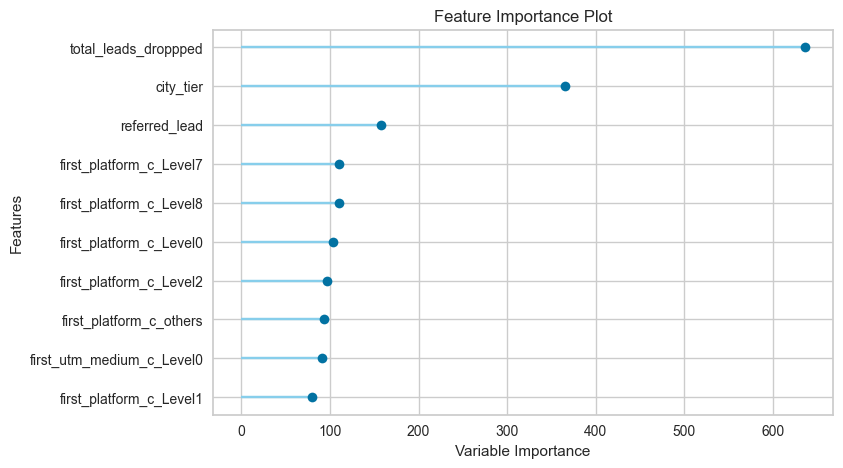

In [13]:
# create feature importance plot
plot_model(lightgbm, plot='feature')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [ ]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.
cols = ['total_leads_droppped', 'city_tier', 'referred_lead', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c', 'app_complete_flag']
dataset_cols = dataset[cols]

In [ ]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
from pycaret.classification import *

exp_lead_scoring = setup(data=dataset_cols, target = 'app_complete_flag',  
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   categorical_features = ['city_tier', 'first_platform_c','first_utm_medium_c', 'first_utm_source_c'],
                   fold_shuffle=True, 
                   session_id = 42,
                   n_jobs=-1,use_gpu=False,
                   log_experiment=False,experiment_name='Lead_scoring',
                   log_plots=False, log_data=False,
                   verbose=True,
                   log_profile=False)

In [ ]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 10,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

In [ ]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret

lightgbm_fs = create_model('lightgbm')

In [ ]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC

tuned_lgbm_optuna,tuner_1 = tune_model(lightgbm_fs, 
                                   search_library = 'optuna',
                                   fold = 10,
                                   optimize = 'auc',
                                   choose_better = True, 
                                   return_tuner=True)

In [ ]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuned_lgbm_optuna)